In [42]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
ACTIONS              = ['UP', 'RIGHT', 'DOWN', 'LEFT', 'WAIT', 'BOMB']
DIRECTIONS           = np.array([(0, -1), (1, 0), (0, 1), (-1, 0)])   # UP, RIGHT, DOWN, LEFT
DEFAULT_DISTANCE     = 1000
BOMB_COOLDOWN_TIME   = 7
COLS = ROWS          = 17
BLAST                = np.array([-3, -2, -1, 1, 2, 3])

## Calculate constant BOMB_MASK one time
BOMB_MASK = np.full((COLS, ROWS, COLS, ROWS), False)

x_inside = lambda x: x > 0 and x < COLS-1
y_inside = lambda y: y > 0 and y < ROWS-1

for x in range(1, COLS-1):
        for y in range(1, ROWS-1):
            if (x % 2 == 1 or y % 2 == 1):
                explosion_spots = [(x, y)]
                if x % 2 == 1:
                    explosion_spots += [(x, y + b) for b in BLAST  if y_inside(y + b)]
                if y % 2 == 1:
                    explosion_spots += [(x + b, y) for b in BLAST  if x_inside(x + b)]
                
                explosion_spots = tuple(np.array(explosion_spots).T)
                BOMB_MASK[(x, y)][explosion_spots] \
                                = True

In [11]:
COINS = 9   # in classic scenario

In [12]:
HUNTER_MODE_IDEA = 2   # 0, 1, 2 or 3

if HUNTER_MODE_IDEA == 0:
    FOE_TRIGGER_DISTANCE = 5
    STRIKING_DISTANCE    = 3
else:
    IDEA2_KILL_PROB = 0.2

In [13]:
def state_to_features (self, game_state):
    """
    *This is not a required function, but an idea to structure your code.*

    Converts the game state to the input of your model, i.e. a feature vector.

    You can find out about the state of the game environment via game_state,
    which is a dictionary. Consult 'get_state_for_agent' in environment.py to see
    what it contains.

    :param game_state:  A dictionary describing the current game board.
    :return: np.array
    """
    
    
    # This is the dict before the game begins and after it ends
    if game_state is None:
        return None


    # 0. Collect relevant game_state info
    own_position      = game_state['self'][3]
    can_place_bomb    = game_state['self'][2]
    crate_map         = game_state['field']
    collectable_coins = game_state['coins']
    bombs             = game_state['bombs']
    explosion_map     = game_state['explosion_map']
    foes              = game_state['others']

    neighbors     = own_position + DIRECTIONS
    foe_positions = [foe[3] for foe in foes]
            

    ## Define variables for updates & reset for each round
    if game_state['step'] == 1:
        self.dumb_bombing_map           = np.zeros((COLS, ROWS)) 
        self.cannot_bomb_ticker         = 0
        self.previous_collectable_coins = []
        self.already_collected_coins    = 0
        
        self.logger.debug(f'stf(): Updated dumb_bombing_map and previous_collectable_coins.')

    ## Count already collected coins
    for coin in self.previous_collectable_coins: 
        if coin not in collectable_coins:
            self.already_collected_coins += 1
    self.logger.debug(f'stf(): # coins collected = {self.already_collected_coins}')
    

    # 1. Calculate proximity map
    distance_map, reachability_map, direction_map = proximity_map(own_position, crate_map)


    # 2. Check for danger and lethal danger
    """
    going_is_dumb   : 
        Intuitive definition : going in that direction is suicidal
        Effect if True       : sets f1-f4 to 0
    waiting_is_dumb : 
        Intuitive definition : staying on own_position is suicidal
        Effect if True       : sets f5 to 0
    bombing_is_dumb : 
        Intuitive definition : placing a bomb on own_position is suicidal?
        Effect if True       : prevents f5 from being 2 via best_crate_bombing_spots() (only mode 1)
    """
    
    waiting_is_dumb = False
    bombing_is_dumb = False
    
    # Don't go where it's invalid or suicidal
    going_is_dumb   = np.array([( (not reachability_map[(x,y)]) or explosion_map[(x,y)] ) for [x,y] in neighbors])
    
    # Don't place a bomb if you're not able to
    if not can_place_bomb: 
        bombing_is_dumb = True 
        self.cannot_bomb_ticker = (self.cannot_bomb_ticker % 6) + 1
        if self.cannot_bomb_ticker == 1:
            self.dumb_bombing_map = np.zeros((COLS, ROWS)) # forget all memorized dumb bombing spots 
            self.logger.debug(f'stf(): Updated dumb_bombing_map.')
    
    # Escape bombs that are about to explode
    for (bomb_position, bomb_timer) in bombs:
        steps_until_explosion    = bomb_timer + 1
        no_future_explosion_mask = np.logical_not(BOMB_MASK[bomb_position])

        if not waiting_is_dumb:
            rescue_distances         = distance_map[reachability_map & no_future_explosion_mask]   # improve by including explosions
            minimal_rescue_distance  = DEFAULT_DISTANCE if (rescue_distances.size == 0) else np.amin(rescue_distances)
            if steps_until_explosion <= minimal_rescue_distance:
                waiting_is_dumb = True
                bombing_is_dumb = True

        safe_directions = np.any(direction_map[reachability_map & no_future_explosion_mask & (distance_map <= steps_until_explosion)], axis = 0)
        going_is_dumb[np.logical_not(safe_directions)] = True

    # Don't place a bomb you can't escape from
    if not bombing_is_dumb:
        no_future_explosion_mask = np.logical_not(BOMB_MASK[own_position])
        rescue_distances         = distance_map[reachability_map & no_future_explosion_mask] # improve by including explosions
        minimal_rescue_distance  = DEFAULT_DISTANCE if (rescue_distances.size == 0) else np.amin(rescue_distances) 
        if minimal_rescue_distance > 4:
            bombing_is_dumb = True
            self.dumb_bombing_map[own_position] = bombing_is_dumb 
    
    # 3. Check game mode
    reachable_coins = select_reachable(collectable_coins, reachability_map)
    
    ## Testing out hunter modes
    if HUNTER_MODE_IDEA == 0:  # Idea 0: Activate Hunter Mode when foe is close
        if len(foes) > 0:
            foe_positions_tuple = tuple(np.array(foe_positions).T)
            min_foe_distance    = np.amin(distance_map[foe_positions_tuple])
        else:
            min_foe_distance    = DEFAULT_DISTANCE    
        hunter_condition = min_foe_distance <= FOE_TRIGGER_DISTANCE or self.already_collected_coins == COINS
    
    else:   # Idea 1: Hunter mode only when no more coins to collect
        hunter_condition = len(foes) > 0 and self.already_collected_coins == COINS
    
    if hunter_condition:
        mode = 2   # Hunter mode
        self.logger.debug(f"Hunter mode")
    elif len(reachable_coins) > 0:
        mode = 0   # Collector mode
        self.logger.debug(f"Collector mode")
    else:
        mode = 1   # Miner mode
        self.logger.debug(f"Miner mode")

 
    # 4. Compute goal direction
    if mode == 0:
        coins_around_me = exclude_from(collectable_coins, own_position)  # Don't have a coin goal on f5
        coins_i_reach   = select_reachable(coins_around_me, reachability_map)
        best_coins      = select_nearest(coins_i_reach, distance_map)
        goals           = make_goals(best_coins, direction_map, own_position)

    if mode == 1:
        crates_destroyed_map = crate_destruction_map(crate_map, bombs)
        sensible_bombing_map = sensible_bombing_spots(reachability_map, self.dumb_bombing_map)
        
        if HUNTER_MODE_IDEA == 0:   # Idea 0: Normal CoinMiner calculations
            best_bomb_spots = best_crate_bombing_spots(distance_map, crates_destroyed_map, sensible_bombing_map)
        else:                       # Idea 2: Include Hunter aspects into bombing spot calculation
            hidden_coin_density = coin_density(crate_map, self.already_collected_coins)
            expected_new_coins  = expected_coins_uncovered(crates_destroyed_map, sensible_bombing_map, hidden_coin_density)
            expected_kills      = expected_foes_killed(foe_positions, own_position)
            best_bomb_spots     = best_bombing_spots(distance_map, expected_new_coins, expected_kills)
        
        goals = make_goals(best_bomb_spots, direction_map, own_position)
        

    if mode == 2:
        if HUNTER_MODE_IDEA == 0:   # Idea 0: Go towards closest foe
            closest_foe = select_nearest(foe_positions, distance_map)
            goals       = make_goals(closest_foe, direction_map, own_position)
            if min_foe_distance <= STRIKING_DISTANCE and not bombing_is_dumb:
                goals[4] = True
        #! TODO: Implement Hunter mode idea 3:
        

    # 5. Assemble feature array
    features = np.full(5, 1)
    
    # Directions (f1 - f4)
    for i in range(4):
        if going_is_dumb[i]:
            features[i] = 0
        elif goals[i]:
            features[i] = 2

    # Own spot (f5)
    if waiting_is_dumb:
        features[4] = 0
    elif goals[4]:   # own spot is a goal
        features[4] = 2
    
    # 6. Do updates for next state_to_features
    self.previous_collectable_coins = collectable_coins

    return features



def proximity_map (own_position, game_field):
    """
    calculates three values for each tile of the game field:
    1. travel time aka. distance from own position
    2. if tile is reachable from own position or blocked
    3. in which directions one can initially go to reach that tile as quick as possible

    Arguments
    ---------
    own_position : tuple (x, y)
        with x and y being current coordinates coordinates of the agent 
        on the game field. Thus 0 < x < COLS-1, 0 < y < ROWS-1.
    game_field   : np.array, shape = (COLS, ROWS)
        = game_state['field']

    Returns
    -------
    travel_time_map         : np.array, shape like game_field, dtype = int
        Reachable tiles have the value of the number of steps it takes to move to them 
        from own_position.
        Unreachable tiles have the value of DEFAULT_TRAVEL_TIME which is much higher than 
        any reachable time.
    reachable_map           : np.array, shape like game_field, dtype = bool
        A boolean mask of travel_time_map that labels reachable tiles as True and 
        unreachable ones as False.
    original_directions_map : np.array, shape = (COLS, ROWS, 4), dtype = bool
        A map of the game_field that holds a 4-element boolean array for every tile.
        Values of the tile's array correspond to the 4 directions UP, RIGHT, DOWN, LEFT 
        which you might from own_position to reach the tile. Those direction which lead you 
        to reach the tile the fastest are marked True, the others False.
        For example, if you can reach a tile the fastest by either going UP or RIGHT at the step
        then its array will look like this [TRUE, TRUE, FALSE, FALSE].
        This map will be important to quickly find the best direction towards coins, crates,
        opponents and more.
    """


    # Setup of initial values
    distance_map  = np.full_like(game_field, DEFAULT_DISTANCE)
    direction_map = np.full((*game_field.shape, 4), False)

    distance_map[own_position] = 0
    for i, dir in enumerate(DIRECTIONS):
        neighbor = tuple(dir + np.array(own_position))
        if game_field[neighbor] == 0:   # If neighbor is a free field
            direction_map[neighbor][i] = True
    

    # Breadth first search for proximity values to all reachable spots
    frontier = [own_position]
    while len(frontier) > 0:
        current = frontier.pop(0)
        
        for dir in DIRECTIONS:
            neighbor = tuple(dir + np.array(current))
            
            # Update travel time to `neighbor` field
            if game_field[neighbor] == 0:   # If neighbor is a free field
                time = distance_map[current] + 1
                if distance_map[neighbor] > time:
                    distance_map[neighbor] = time
                    frontier.append(neighbor)
                    
                    # Update original direction for `neighbor` field
                    if time > 1:
                        direction_map[neighbor] = direction_map[current]
                        
                # Combine orginial directions if travel times are equal
                elif distance_map[neighbor] == time:
                    direction_map[neighbor] = np.logical_or(
                        direction_map[neighbor], direction_map[current])


    # Derivation of reachability_map
    reachability_map = distance_map != DEFAULT_DISTANCE


    return distance_map, reachability_map, direction_map



def select_reachable (positions, reachability_map):
    """
    """

    if len(positions) > 0:
        positions_array     = np.array(positions)
        positions_tuple     = tuple(positions_array.T)
        reachable_mask      = reachability_map[positions_tuple]
        reachable_positions = positions_array[reachable_mask] 
    else:
        reachable_positions = np.array(positions)

    return reachable_positions



def exclude_from(list, item):
    if item in list:
        smaller_list = list.copy()
        smaller_list.remove(item)
        return smaller_list
    else:
        return list



def select_nearest (positions, distance_map):
    """
    """

    if len(positions) > 0:
        positions_array   = np.array(positions)
        positions_tuple   = tuple(positions_array.T)
        min_distance_mask = distance_map[positions_tuple] == np.amin(distance_map[positions_tuple])
        nearest_positions = positions_array[min_distance_mask]
    else:
        nearest_positions = np.array([])    
    
    return nearest_positions



def make_goals (positions, direction_map, own_position):
    """
    """

    # Direction goals
    goals = np.full(5, False)
    if len(positions) > 0:
        positions_tuple  = tuple(positions.T)
        goal_directions  = direction_map[positions_tuple]
        goals[:4]        = np.any(goal_directions, axis = 0)
        
        # Check if there's a goal on the own_position
        goal_on_own_spot = (np.array(own_position) == positions).all(axis = 1).any()   # numpy-speak for "own_position in position"
        goals[4]         = goal_on_own_spot
    
    return goals



def crate_destruction_map (crate_map, bombs):
    """
    """

    if len(bombs) > 0:
        bomb_array       = np.array([bomb[0] for bomb in bombs])   # Bomb positions
        bomb_tuple       = tuple(bomb_array.T)
        explosion_zones  = np.any(BOMB_MASK[bomb_tuple], axis = 0)   # All fields that will be destroyed due to the current bombs.
        unexploded_zones = np.logical_not(explosion_zones)   # All fields that will be unharmed by the current bombs
    else:
        unexploded_zones = np.full_like(crate_map, True)
    
    crate_mask            = crate_map == 1   # Only show the crate positions
    crates_remaining_mask = np.logical_and(crate_mask, unexploded_zones)
    number_of_crates_destroyed_map \
                          = np.sum(np.logical_and(crates_remaining_mask, BOMB_MASK), axis = (-2, -1))
    
    return number_of_crates_destroyed_map



def sensible_bombing_spots (reachability_map, dumb_bombing_map):
    return reachability_map * np.logical_not(dumb_bombing_map)



def best_crate_bombing_spots (distance_map, number_of_destroyed_crates_map, sensible_bombing_map):
    """
    """

    total_time_map             = distance_map + BOMB_COOLDOWN_TIME   # Time until next bomb can be placed
    reachable_crates_destroyed = sensible_bombing_map * number_of_destroyed_crates_map   # Filtering out the reachable crate_destruction spots (precaution).
    destruction_speed_map      = reachable_crates_destroyed / total_time_map
    max_destruction_speed      = np.amax(destruction_speed_map)
    
    if max_destruction_speed > 0:
        best_spots_mask = np.isclose(destruction_speed_map, max_destruction_speed)   # Safer test for float equality
        best_spots      = np.array(np.where(best_spots_mask)).T
    else:
        best_spots      = np.array([])
    
    return best_spots



def coin_density (crate_map, already_collected_coins):
    number_of_crates       = np.sum(crate_map == 1)
    number_of_hidden_coins = COINS - already_collected_coins
    if number_of_crates > 0:
        hidden_coin_density = number_of_hidden_coins / number_of_crates
    else:
        hidden_coin_density = 0
    
    return hidden_coin_density



def expected_coins_uncovered (number_of_destroyed_crates_map, sensible_bombing_map, coin_density):
    expected_crates_destroyed = sensible_bombing_map * number_of_destroyed_crates_map

    return coin_density * expected_crates_destroyed



def expected_foes_killed (foe_positions, own_position):

    # Direct distances to all foes
    if len(foe_positions) > 0:
        own_bomb_spread    = BOMB_MASK[own_position]
        foe_position_array = np.array(foe_positions)
        own_position_array = np.array(own_position)
        distances_to_me    = np.sum(np.abs(foe_position_array - own_position_array), axis = 1)

        # Which foes are affected by the explosion?
        foe_positions_tuple = tuple(foe_position_array.T)
        foes_in_explosion   = own_bomb_spread[foe_positions_tuple]  # Boolean mask

        # Estimate for kill probability
        kill_probabilities = IDEA2_KILL_PROB * (4 - distances_to_me) / 3 * foes_in_explosion
        expected_kills     = np.sum(kill_probabilities)
    else:
        expected_kills = 0

    return expected_kills



def best_bombing_spots (distance_map, expected_coins, expected_kills):
    
    points_for_coins = 1
    points_for_kills = 5

    time_until_next_bombing = distance_map + BOMB_COOLDOWN_TIME   # Time until next bomb can be placed
    expected_points_map     = expected_coins * points_for_coins + expected_kills * points_for_kills
    point_speed_map         = expected_points_map / time_until_next_bombing
    max_point_speed         = np.amax(point_speed_map)

    if max_point_speed > 0:
        best_spots_mask = np.isclose(point_speed_map, max_point_speed)   # Safer test for float equality
        best_spots      = np.array(np.where(best_spots_mask)).T
    else:
        best_spots      = np.array([])
    
    return best_spots


In [20]:
"""
# Expected implementation
hidden_coin_density = coin_density(crate_map, self.already_collected_coins)
expected_new_coins  = expected_coins_uncovered(crates_destroyed, sensible_bombing_map, hidden_coin_density)
expected_kills      = expected_foes_killed(foe_positions, own_position)
best_bomb_spots     = best_bombing_spots(distance_map, expected_new_coins, expected_kills)
""";

## Testing & prototyping

### Test data

In [21]:
# Test crate maps
empty_game_field = np.array(
    [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]
)

halffull_game_field = np.array(
    [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
     [-1,  0,  0,  1,  1,  1,  0,  1,  1,  1,  1,  0,  1,  0,  0,  0, -1],
     [-1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  0, -1],
     [-1,  1,  0,  1,  0,  1,  1,  0,  0,  1,  1,  1,  0,  1,  1,  1, -1],
     [-1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  0, -1,  1, -1,  1, -1],
     [-1,  1,  0,  1,  0,  0,  0,  1,  1,  1,  0,  0,  1,  0,  1,  1, -1],
     [-1,  0, -1,  0, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  0,  0,  1,  1,  0,  1,  1,  0,  1,  1,  1,  0,  1,  1,  1, -1],
     [-1,  1, -1,  1, -1,  0, -1,  0, -1,  0, -1,  0, -1,  1, -1,  0, -1],
     [-1,  1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  0,  0,  0,  0, -1],
     [-1,  1, -1,  0, -1,  0, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  1,  1,  0,  1, -1],
     [-1,  1, -1,  1, -1,  0, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, -1],
     [-1,  0, -1,  1, -1,  0, -1,  0, -1,  1, -1,  1, -1,  1, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  0,  0, -1],
     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]
)

packed_game_field = np.array(
    [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
     [-1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0, -1],
     [-1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  1, -1,  0, -1],
     [-1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1, -1],
     [-1,  1, -1,  1, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  1,  1,  1,  1,  1,  0,  1,  0,  1,  0,  1,  0,  0,  1,  0, -1],
     [-1,  1, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  0, -1],
     [-1,  0,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1, -1],
     [-1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  1, -1],
     [-1,  1,  1,  0,  1,  1,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1, -1],
     [-1,  1, -1,  1, -1,  1, -1,  0, -1,  1, -1,  1, -1,  1, -1,  0, -1],
     [-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  0, -1],
     [-1,  1, -1,  0, -1,  1, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  0,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  0,  1,  1,  0, -1],
     [-1,  0, -1,  1, -1,  0, -1,  0, -1,  0, -1,  0, -1,  1, -1,  0, -1],
     [-1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  0,  0, -1],
     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]
)

In [22]:
# Test coin lists
coins_none           = []
coins_empty_field    = [(7, 7), (7, 8), (9, 5), (11, 3), (11, 7), (13, 5)]
coins_halffull_field = [(5, 5), (9, 5), (11, 3), (11, 7), (13, 5), (14, 1), (15, 1), (15, 7)]

In [23]:
# Test positions
positions_empty_field    = [(11, 5), (9, 7), (7, 5), (13, 9), (9, 9), (5, 7), (5, 8), (11, 7)]
positions_halffull_field = [(11, 5), (13, 7), (15, 4), (13, 2), (7, 5), (13, 8), (14, 1), (13, 5)]
positions_packed_field   = [(15, 1), (1, 1)]

In [24]:
# Test bomb placements
bombs_none = []
bombs_some = [((11, 5), 4), ((1, 1), 2), ((7, 6), 0), ((5, 11), 1)]
bombs_many = [((11, 5), 4), ((1, 1), 2), ((7, 6), 0), ((5, 11), 1), ((5, 7), 2), ((7, 13), 3), ((15, 12), 0)]

### Testing `best_bombing_spots()`

In [83]:
def best_bombing_spots (distance_map, expected_coins, expected_kills):
    
    points_for_coins = 1
    points_for_kills = 5

    time_until_next_bombing = distance_map + BOMB_COOLDOWN_TIME   # Time until next bomb can be placed
    expected_points_map     = expected_coins * points_for_coins + expected_kills * points_for_kills
    point_speed_map         = expected_points_map / time_until_next_bombing
    max_point_speed         = np.amax(point_speed_map)

    if max_point_speed > 0:
        best_spots_mask = np.isclose(point_speed_map, max_point_speed)   # Safer test for float equality
        best_spots      = np.array(np.where(best_spots_mask)).T
    else:
        best_spots      = np.array([])
    
    return best_spots

In [84]:
crate_map               = halffull_game_field
bombs                   = bombs_some
own_position            = (13, 5)
foe_positions           = [(13, 6), (11, 4), (10, 5)] #[(11, 4), (1, 1)] [(13, 6), (11, 4), (10, 5)]   # []
dumb_bombing_map        = np.zeros_like(crate_map)
already_collected_coins = 3

distance_map, reachability_map, direction_map = proximity_map(own_position, crate_map)

crates_destroyed_map = crate_destruction_map(crate_map, bombs)
sensible_bombing_map = sensible_bombing_spots(reachability_map, dumb_bombing_map)
hidden_coin_density  = coin_density(crate_map, already_collected_coins)
expected_coins_map   = expected_coins_uncovered(crates_destroyed_map, sensible_bombing_map, hidden_coin_density)
expected_kills       = expected_foes_killed(foe_positions, own_position)

best_bomb_spots      = best_bombing_spots(distance_map, expected_coins_map, expected_kills)

In [85]:
best_bomb_spots

array([[13,  5]])

### Testing `expected_foes_killed()`

In [57]:
def expected_foes_killed (foe_positions, own_position):

    # Direct distances to all foes
    if len(foe_positions) > 0:
        own_bomb_spread    = BOMB_MASK[own_position]
        foe_position_array = np.array(foe_positions)
        own_position_array = np.array(own_position)
        distances_to_me    = np.sum(np.abs(foe_position_array - own_position_array), axis = 1)

        # Which foes are affected by the explosion?
        foe_positions_tuple = tuple(foe_position_array.T)
        foes_in_explosion   = own_bomb_spread[foe_positions_tuple]  # Boolean mask

        # Estimate for kill probability
        kill_probabilities = IDEA2_KILL_PROB * (4 - distances_to_me) / 3 * foes_in_explosion
        expected_kills     = np.sum(kill_probabilities)
    else:
        expected_kills = 0

    return expected_kills

In [60]:
crate_map               = halffull_game_field
bombs                   = bombs_some
own_position            = (13, 5)
foe_positions           = [(11, 4), (1, 1)] #[(13, 6), (11, 4), (10, 5)]   # []
dumb_bombing_map        = np.zeros_like(crate_map)
already_collected_coins = 1

distance_map, reachability_map, direction_map = proximity_map(own_position, crate_map)

crates_destroyed     = crate_destruction_map(crate_map, bombs)
sensible_bombing_map = sensible_bombing_spots(reachability_map, dumb_bombing_map)
hidden_coin_density  = coin_density(crate_map, already_collected_coins)
expected_new_coins   = expected_coins_uncovered(crates_destroyed, sensible_bombing_map, hidden_coin_density)

expected_kills       = expected_foes_killed(foe_positions, own_position)

In [61]:
print(expected_kills)

0.0


### Testing `expected_coins_uncovered()`

In [32]:
def expected_coins_uncovered (number_of_destroyed_crates_map, sensible_bombing_map, coin_density):
    expected_crates_destroyed = sensible_bombing_map * number_of_destroyed_crates_map

    return coin_density * expected_crates_destroyed

In [49]:
crate_map               = halffull_game_field
bombs                   = bombs_some
own_position            = (13, 5)
dumb_bombing_map        = np.zeros_like(crate_map)
already_collected_coins = 1

distance_map, reachability_map, direction_map = proximity_map(own_position, crate_map)

crates_destroyed     = crate_destruction_map(crate_map, bombs)
sensible_bombing_map = sensible_bombing_spots(reachability_map, dumb_bombing_map)
hidden_coin_density  = coin_density(crate_map, already_collected_coins)

expected_new_coins   = expected_coins_uncovered(crates_destroyed, sensible_bombing_map, hidden_coin_density)

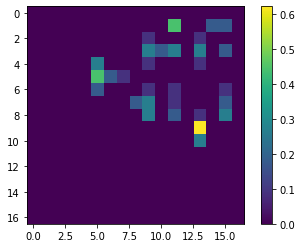

In [50]:
plt.imshow(expected_new_coins.T)
plt.colorbar()
plt.show()

### Testing `hidden_coin_density()`

In [25]:
def coin_density (crate_map, already_collected_coins):
    number_of_crates       = np.sum(crate_map == 1)
    number_of_hidden_coins = COINS - already_collected_coins
    if number_of_crates > 0:
        hidden_coin_density = number_of_hidden_coins / number_of_crates
    else:
        hidden_coin_density = 0
    
    return hidden_coin_density

In [31]:
crate_map               = empty_game_field
already_collected_coins = 9

print(np.sum(crate_map == 1))
coin_density(crate_map, already_collected_coins)

0


0

### Testing `select_nearest`()

In [ ]:
crate_map    = halffull_game_field
own_position = positions_halffull_field[7]
coins        = coins_none

distance_map, reachability_map, direction_map \
                = proximity_map(own_position, crate_map)

coins_around_me = exclude_from(coins, own_position)  # Don't have a coin goal on f5
coins_i_reach   = select_reachable(coins_around_me, reachability_map)
best_coins      = select_nearest(coins_i_reach, distance_map)
goals           = make_goals(best_coins, direction_map, own_position)

In [ ]:
print(f"own_spot       : {own_position}")
print(f"coins          : {coins}")
print(f"coins_around_me: {coins_around_me}")
print(f"coins_i_reach  : \n{coins_i_reach}")
print(f"best_coins     : \n{best_coins}")
print(f"goals          : \n{goals}")


own_spot       : (13, 5)
coins          : []
coins_around_me: []
coins_i_reach  : 
[]
best_coins     : 
[]
goals          : 
[False False False False False]
